# Calculate distances and find neighbors

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import poligrain as plg

## Point-to-point distances

### Get PWS dataset

In [2]:
!curl -OL https://github.com/OpenSenseAction/training_school_opensene_2023/raw/main/data/pws/data_PWS_netCDF_AMS_float.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10.7M  100 10.7M    0     0  4432k      0  0:00:02  0:00:02 --:--:-- 5450k


In [3]:
ds_pws = xr.open_dataset("data_PWS_netCDF_AMS_float.nc")

# fix some issues with this dataset
ds_pws["time"] = pd.to_datetime(ds_pws.time.data, unit="s")
ds_pws["lon"] = ("id", ds_pws.lon.data)
ds_pws["lat"] = ("id", ds_pws.lat.data)

### Project cooridnates from lon-lat to UTM zone for Europe

To do meaningful distance calculations we have to project the lon-lat coordinates first.

Info on the UTM zone 32N projection `'EPSG:25832'` that is used can be found [here](https://epsg.io/25832#google_vignette)

Note that `plg.spatial.project_coordinates` can also use a different source coordinate system, but its default is WGS 84 (lon and lat in degrees), which is `'EPSG:4326'` 

In [4]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    ds_pws.lon, ds_pws.lat, "EPSG:25832"
)

In [5]:
ds_pws

<xarray.Dataset>
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    lat        (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    lon        (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall   (id, time) float64 ...
Attributes:
    title:         PWS data from Amsterdam
    institution:   Wageningen University and Research, Department of Environm...
    history:       Test Version 0.1
    references:    https://doi.org/10.1029/2019GL083731
    date_created:  2022-10-18 10:32:00
    Conventions:   OPENSENSE V0
    location:      Amsterdam Metropolitan Area
    source:        Netamo
    comment:

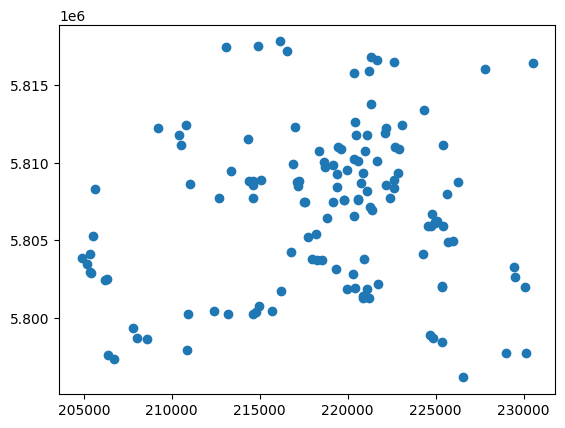

In [6]:
plt.scatter(ds_pws.x, ds_pws.y);

### Distance matrix

#### Calculate distance matrix

Beware that the distance matrix can become quite large when using large datasets, e.g. 800 MB if you use 10,000 stations against 10,000 stations from a country-wide PWS dataset, and calculation can take tens of seconds. We might add the option to calculate a sparse distance matrix only up the certain distances later, which reduced size and computation time signficantly.

For the typicall use case to find nearby stations, you can just use the nearest neighbor lookup described below for large datasets. The distance matrix can still be quite nice and handy for small regional datasets.

In [7]:
distance_matrix = plg.spatial.calc_point_to_point_distances(
    ds_pws,
    ds_pws,
)

distance_matrix

<xarray.DataArray (id: 134, id_neighbor: 134)>
array([[    0.        ,   518.79828487,   531.99603941, ...,
        28532.23134009, 25291.03668667, 25994.5064412 ],
       [  518.79828487,     0.        ,   728.38027968, ...,
        28493.8273213 , 24995.94592241, 25633.14869253],
       [  531.99603941,   728.38027968,     0.        , ...,
        28000.75903421, 24846.06853717, 25603.62271956],
       ...,
       [28532.23134009, 28493.8273213 , 28000.75903421, ...,
            0.        , 14448.29575676, 18710.76846276],
       [25291.03668667, 24995.94592241, 24846.06853717, ...,
        14448.29575676,     0.        ,  4264.61589559],
       [25994.5064412 , 25633.14869253, 25603.62271956, ...,
        18710.76846276,  4264.61589559,     0.        ]])
Coordinates:
  * id           (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
  * id_neighbor  (id_neighbor) <U6 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'

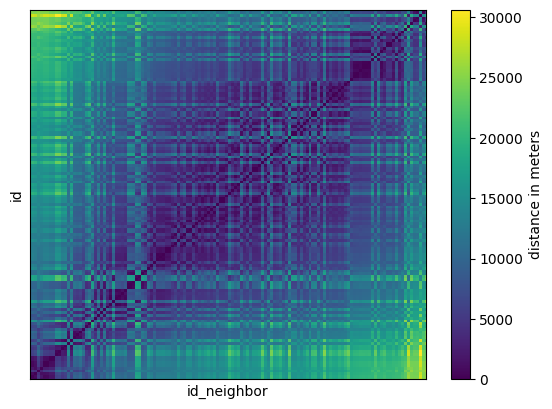

In [8]:
distance_matrix.plot(cbar_kwargs={"label": "distance in meters"})
plt.xticks([])
plt.yticks([]);

#### Plot locations with distance to selected station

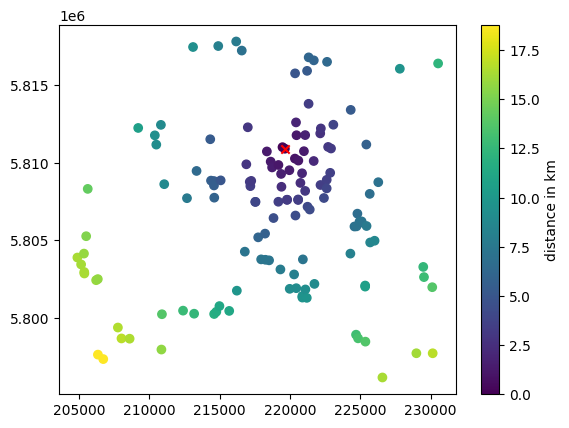

In [9]:
pws_id = "ams63"

sc = plt.scatter(ds_pws.x, ds_pws.y, c=distance_matrix.sel(id=pws_id) / 1e3)
plt.scatter(ds_pws.sel(id=pws_id).x, ds_pws.sel(id=pws_id).y, c="r", marker="x")
plt.colorbar(sc, label="distance in km");

#### Select neighbors within certain range from distance matrix

Note that this can be done more easily with the nearest neighbor lookup shown below. But you might findet having the distance matrix and getting the neigbors from there a nicer solution.

In [10]:
pws_id = "ams63"

max_distance = 3e3  # this is in meteres

distances = distance_matrix.sel(id=pws_id)
selected_neighbor_ids = ds_pws.id.data[distances < max_distance]
selected_neighbor_ids

array(['ams41', 'ams42', 'ams51', 'ams54', 'ams55', 'ams58', 'ams60',
       'ams61', 'ams62', 'ams63', 'ams67', 'ams69', 'ams70', 'ams71',
       'ams74', 'ams78', 'ams80', 'ams83', 'ams84', 'ams94', 'ams96',
       'ams97'], dtype='<U6')

### Nearest neighbor lookup

This uses `scipy.spatial.KDTree` for fast lookup of nearest neighbors and distance calculation. In the resulting `xarray.Dataset` the IDs of the neighboring stations are `None` for the cases where their distance is larger than `max_distance`.

#### Get N closest points for two point datasets

In [11]:
closest_neigbors = plg.spatial.get_closest_points_to_point(
    ds_points=ds_pws,
    ds_points_neighbors=ds_pws,
    max_distance=max_distance,
    n_closest=25,
)

In [12]:
closest_neigbors

<xarray.Dataset>
Dimensions:      (id: 134, n_closest: 25)
Coordinates:
  * id           (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
Dimensions without coordinates: n_closest
Data variables:
    distance     (id, n_closest) float64 0.0 518.8 532.0 ... inf inf inf
    neighbor_id  (id, n_closest) object 'ams1' 'ams2' 'ams3' ... None None None

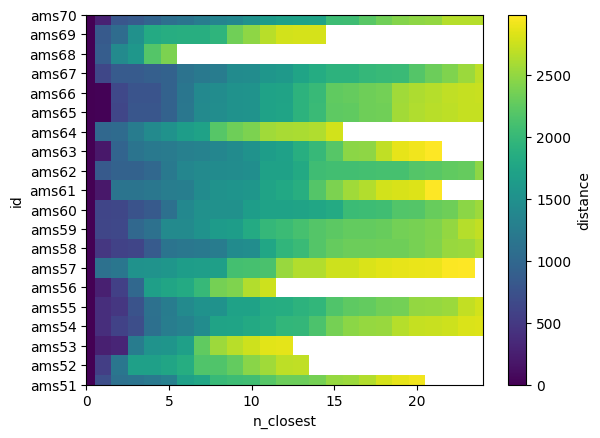

In [13]:
closest_neigbors.isel(id=slice(50, 70)).distance.plot();

One interesting thing might be the distance of the closest station, which is at index 1 of `n_closest` in our case because at index 0 is each station itself.

Note that there is no data point if there is not neigbor within `max_distance`.

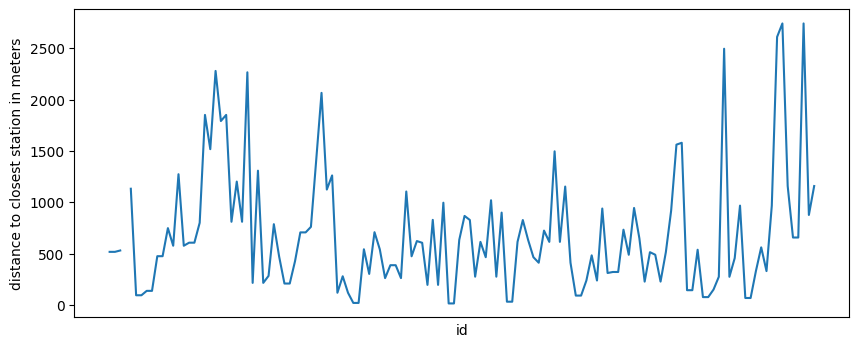

In [14]:
closest_neigbors.isel(n_closest=1).distance.plot(figsize=(10, 4))
plt.xticks([])
plt.ylabel("distance to closest station in meters");

#### Get IDs of closest points

We can also get the station IDs of the closest neighbors. Note that they are different for each target station ID and they are sorted by ascending distance.

In [15]:
pws_id = "ams63"

neighbor_ids = closest_neigbors.sel(id=pws_id).neighbor_id.dropna(dim="n_closest")
neighbor_ids

<xarray.DataArray 'neighbor_id' (n_closest: 22)>
array(['ams63', 'ams61', 'ams70', 'ams58', 'ams71', 'ams74', 'ams51',
       'ams54', 'ams83', 'ams67', 'ams55', 'ams60', 'ams84', 'ams69',
       'ams80', 'ams94', 'ams78', 'ams62', 'ams96', 'ams97', 'ams42',
       'ams41'], dtype=object)
Coordinates:
    id       <U6 'ams63'
Dimensions without coordinates: n_closest

These should be the same neighboring station IDs as derive from the distance matrix above, since we have chosen the same ID as target station. This is, however, only true if `n_closets` does not cut off the list for `get_closest_points_to_point()`. For the chosen values in this example the two sets of neighboring IDs should be the same. Let's check that.

In [16]:
set(selected_neighbor_ids) == set(neighbor_ids.data)

True

#### Plot stations and mark closest neighbors

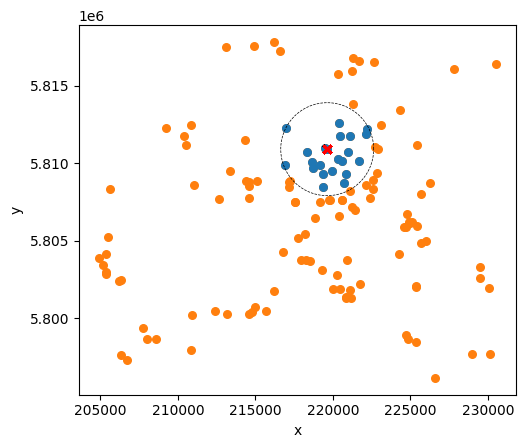

In [17]:
fig, ax = plt.subplots()
ax.set_aspect("equal")

ax.scatter(ds_pws.x, ds_pws.y, c="C1", s=30)

neighbor_ids = closest_neigbors.sel(id=pws_id).neighbor_id.dropna(dim="n_closest")
ds_pws_neighbors = ds_pws.sel(id=neighbor_ids)
ax.scatter(ds_pws_neighbors.x, ds_pws_neighbors.y, c="C0", s=30)

ds_pws.sel(id=pws_id).plot.scatter(x="x", y="y", color="r", s=30, marker="x")

# Plot a circel with max_distance to see if the selections fits
an = np.linspace(0, 2 * np.pi, 100)
ax.plot(
    ds_pws.x.sel(id=pws_id).data + max_distance * np.cos(an),
    ds_pws.y.sel(id=pws_id).data + max_distance * np.sin(an),
    color="k",
    linestyle="--",
    linewidth=0.5,
)
plt.title("");

Note that not all stations within the circle will be marked in case that `n_closest` cuts off the list of nearby stations.